<a href="https://colab.research.google.com/github/antondremak91/customer_segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Customer segmentation data from Kaggle

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market.

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

We are required to help the manager to predict the right group of the new customers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/codingDojo/data_science/project_2/cars_Train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
#Droping ID column
df.drop(columns='ID', inplace=True)

This is a classification problem with target "Segmentation" column (A, B, C, D ).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 630.4+ KB


This datasrt has 11 features and 8068 rows of data.

In [6]:
df.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
df.duplicated().sum()

417

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,Age,Work_Experience,Family_Size
count,7651.000000,6845.000000,7319.000000
mean,43.584368,2.728415,2.852712
std,16.525300,3.449225,1.549283
min,18.000000,0.000000,1.000000
25%,31.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,5.000000,4.000000
max,89.000000,14.000000,9.000000


Age ranges from 18 to 89, work experiance from 0 to 14 and family size from 1 to 9. 

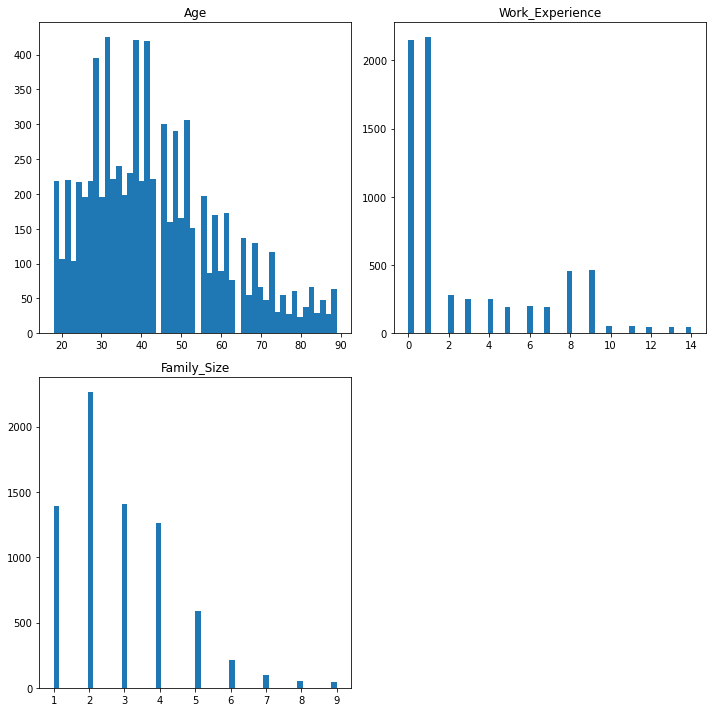

In [11]:
#plot the distribution of numerical features
df.hist(bins=50,figsize=(10,10),grid=False)
plt.tight_layout()
plt.show()

In [12]:
df['Segmentation'].value_counts()

D    2096
A    1920
C    1821
B    1814
Name: Segmentation, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


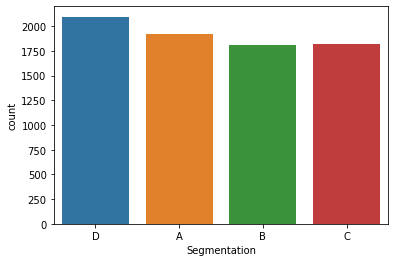

In [13]:
sns.countplot(df['Segmentation']);

Dataset looks balanced

In [14]:
df['Gender'].value_counts()

Male      4163
Female    3488
Name: Gender, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


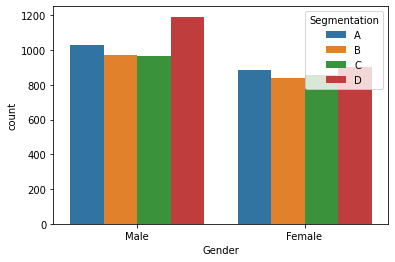

In [15]:
sns.countplot('Gender', hue='Segmentation', data=df, hue_order=['A','B','C','D']);

There is more Male buyers overall especialy in "D" segment.

In [16]:
df['Ever_Married'].value_counts()

Yes    4437
No     3074
Name: Ever_Married, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


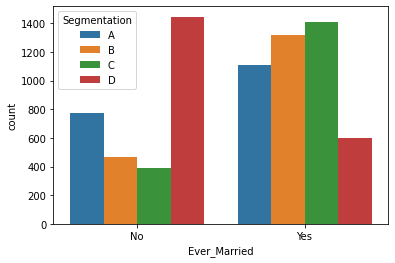

In [17]:
sns.countplot('Ever_Married', hue='Segmentation', data=df, hue_order=['A','B','C','D']);

Also majority of not-married customers are in "D" segment.

In [18]:
df['Profession'].value_counts()

Artist           2360
Healthcare       1173
Entertainment     934
Engineer          689
Doctor            682
Lawyer            581
Executive         575
Marketing         290
Homemaker         243
Name: Profession, dtype: int64

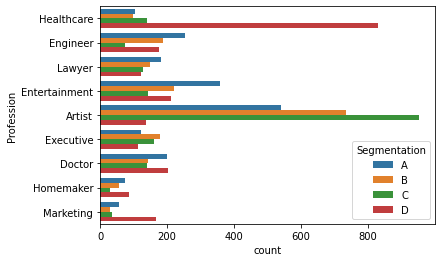

In [19]:
sns.countplot(y='Profession', hue='Segmentation', data=df, hue_order=['A','B','C','D']);

Most of "D" segment customers employed in healthcare, "C" segment mostly artist, also there is many artists in "A" and "B" segment.

In [20]:
df['Var_1'].value_counts()

Cat_6    4860
Cat_4    1074
Cat_3     811
Cat_2     412
Cat_7     203
Cat_1     131
Cat_5      84
Name: Var_1, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


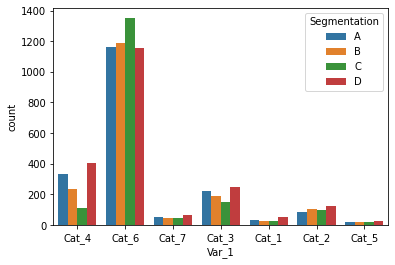

In [21]:
sns.countplot('Var_1', hue='Segmentation', data=df, hue_order=['A','B','C','D']);

Most of the segments are in "cat_6".

In [22]:
df['Graduated'].value_counts()

Yes    4725
No     2848
Name: Graduated, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


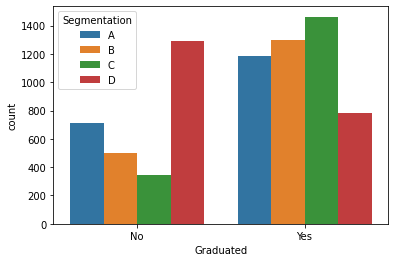

In [23]:
sns.countplot('Graduated', hue='Segmentation', data=df, hue_order=['A','B','C','D']);

Majority of "D" segment are not gratuated. The majority of other segments are.

In [24]:
df['Work_Experience'].value_counts()

1.0     2170
0.0     2149
9.0      460
8.0      457
2.0      282
3.0      251
4.0      248
6.0      203
7.0      192
5.0      191
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: Work_Experience, dtype: int64

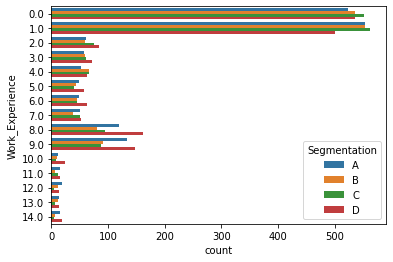

In [25]:
sns.countplot(y='Work_Experience', hue='Segmentation', data=df, hue_order=['A','B','C','D']);

In [26]:
df.groupby('Profession').mean()

,Age,Work_Experience,Family_Size
Profession,,,
Artist,46.168220,2.814849,2.525535
Doctor,37.249267,2.625000,2.881098
Engineer,41.801161,2.598706,2.993967
Entertainment,42.968951,2.782763,2.794183
Executive,50.928696,2.373016,3.445633
Healthcare,27.434783,2.830769,3.688347
Homemaker,38.008230,6.437500,2.252336
Lawyer,74.903614,1.268000,1.956204
Marketing,36.900000,2.633466,3.076923


In [27]:
df.groupby('Age').mean()

,Work_Experience,Family_Size
Age,,
18,2.905263,4.059406
19,2.888889,4.137255
20,2.255556,3.787879
21,2.418605,4.271739
22,2.366972,4.043103
...,...,...
85,0.705882,1.777778
86,1.708333,1.807692
87,0.954545,1.666667


For some reason it looks like youngest customers got higher work experiance than older ones.

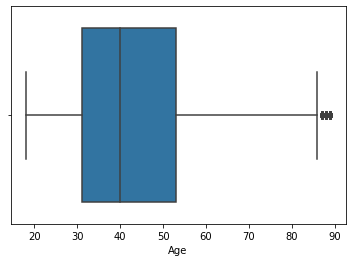

In [28]:
sns.boxplot(x='Age', data=df);

Here we can see that the median age for our customers is 40, with most of them in 30 to 50. Also there are some outliers close to 90 y.o.

In [29]:
df['Age'].value_counts()

35    240
37    230
43    222
33    222
42    221
     ... 
87     27
77     27
76     25
80     23
85     20
Name: Age, Length: 67, dtype: int64

In [30]:
# Finding outliers
age_outl = df[df['Age'] > 87]
age_outl

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
321,Male,Yes,89,Yes,Lawyer,13.0,Low,1.0,Cat_6,A
395,Female,Yes,89,No,Lawyer,3.0,High,1.0,Cat_6,D
699,Male,Yes,88,No,Executive,0.0,Low,1.0,Cat_6,A
753,Female,Yes,88,No,Lawyer,0.0,High,2.0,Cat_6,B
943,Male,Yes,88,Yes,Lawyer,NaN,Low,NaN,Cat_6,B
...,...,...,...,...,...,...,...,...,...,...
7262,Male,Yes,89,No,Lawyer,0.0,Low,NaN,Cat_6,A
7778,Female,Yes,88,Yes,Lawyer,NaN,High,2.0,Cat_6,C
7864,Male,Yes,88,Yes,Artist,0.0,High,2.0,Cat_6,C
7866,Male,Yes,88,Yes,Marketing,0.0,High,2.0,Cat_6,C


This looks very strange to me that a lot of this people of higher age having so little or no work experience especialy being executives, lawyers or working in marketing.

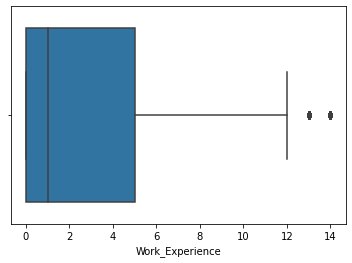

In [31]:
sns.boxplot(x='Work_Experience', data=df);

Majority of our customers have vary little work experience with some outliers with work experience over 12 years.

In [32]:
# Finding outliers
we_outl = df[df['Work_Experience'] > 12]
we_outl

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
22,Male,Yes,33,Yes,Artist,13.0,Low,2.0,Cat_3,A
42,Female,No,27,Yes,Artist,14.0,Low,3.0,Cat_6,A
55,Male,Yes,32,Yes,Artist,14.0,Average,2.0,Cat_6,B
321,Male,Yes,89,Yes,Lawyer,13.0,Low,1.0,Cat_6,A
338,Female,No,38,Yes,Doctor,14.0,Low,1.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...
7798,Female,No,36,Yes,Artist,13.0,Low,1.0,Cat_6,D
7835,Male,Yes,39,Yes,Artist,13.0,Low,2.0,Cat_6,B
7990,Female,No,43,Yes,Entertainment,14.0,Low,1.0,Cat_6,A
8028,Male,Yes,40,Yes,Artist,13.0,High,1.0,Cat_4,D


After analyzing our data by segments i wouls assume that:
- Seament "A" mostly includes male, married, artist, graduated, with 1 year or less work experiance and belomg in cat_6;
- Segment "B": male, married, artist, graduated, with 1 year or less work experiance and belong in cat_6;
- Segment "C": male, married, artist, graduated, with 1 year or less work experiance and belong in cat_6;
- Segment "D": male, not married, healthcare worker, not gratuated, with 1 year or less work experiance and belong in cat_6;

Since majority of our data has very similar values, i would use "Most frequent" form of imputation of missing data.

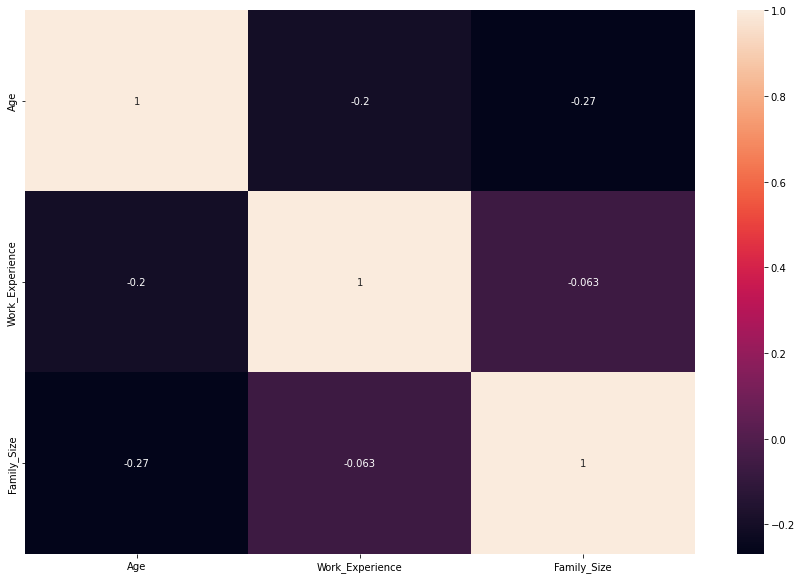

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, ax=ax)

There are no significant correlations in data.

Lets train test split and create column transformer and pipeline for each data type.

In [34]:
y = df['Segmentation']
X = df.drop(columns='Segmentation')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
# Converting string names of the classes to numeric values
df['Spending_Score'] = df['Spending_Score'].replace({'Low': 0, 'Medium': 1, 'High' : 2})

# Select columns
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Instantiate Transformers
median_imputer = SimpleImputer(strategy='median')
freq_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Make Pipelines for each column type
num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe_encoder)

# Match pipe to column
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

# Make column Transformer
column_transformer = make_column_transformer(num_tuple, cat_tuple)

### Baseline

In [37]:
#Establishing baseline 
baseline = DummyClassifier(strategy='most_frequent')

baseline_pipe = make_pipeline(column_transformer, baseline)

baseline_pipe.fit(X_train, y_train)

baseline_preds = baseline_pipe.predict(X_test)

In [38]:
print('Training accuracy:', baseline_pipe.score(X_train, y_train))
print('Testing accuracy:', baseline_pipe.score(X_test, y_test))

Training accuracy: 0.27727431160683164
Testing accuracy: 0.2639832723470988


In [39]:
#Classification report
print('Dummy classification report:\n,', classification_report(y_test, baseline_preds))

Dummy classification report:
,               precision    recall  f1-score   support

           A       0.00      0.00      0.00       484
           B       0.00      0.00      0.00       458
           C       0.00      0.00      0.00       466
           D       0.26      1.00      0.42       505

    accuracy                           0.26      1913
   macro avg       0.07      0.25      0.10      1913
weighted avg       0.07      0.26      0.11      1913



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our baseline scores are very bad.

### Desision tree classifier

In [40]:
#Instance of the Model Decision Tree Classifier
dec_tree = DecisionTreeClassifier(random_state = 42)

dec_tree_pipe = make_pipeline(column_transformer, dec_tree)

dec_tree_pipe.fit(X_train, y_train)

dec_tree_preds = dec_tree_pipe.predict(X_test)

In [41]:
print('Training accuracy:', dec_tree_pipe.score(X_train, y_train))
print('Testing accuracy:', dec_tree_pipe.score(X_test, y_test))

Training accuracy: 0.9574764726385501
Testing accuracy: 0.4087820177731312


In [42]:
#Classification report
print('Dec tree classification report:\n,', classification_report(y_test, dec_tree_preds))

Dec tree classification report:
,               precision    recall  f1-score   support

           A       0.35      0.36      0.35       484
           B       0.30      0.31      0.31       458
           C       0.41      0.39      0.40       466
           D       0.57      0.56      0.56       505

    accuracy                           0.41      1913
   macro avg       0.41      0.41      0.41      1913
weighted avg       0.41      0.41      0.41      1913



Results look better, but lets try to tune depth.

In [43]:
dec_tree.get_depth()

32

#### Dec tree param tuning.

In [44]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [65]:
max_depth_range = list(range(2, 32))

accuracy = []
for depth in max_depth_range:
    dec_tree = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 42)
    dec_tree_pipe.fit(X_train, y_train)
    score = dec_tree_pipe.score(X_test, y_test)
    accuracy.append(score)

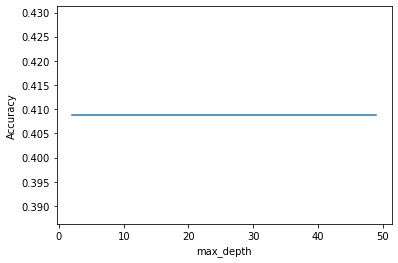

In [66]:
plt.plot(max_depth_range, accuracy)
plt.xlabel('max_depth')
plt.ylabel('Accuracy');

### Bagging trees

In [45]:
# Instance of the Model Bagging Tree Classifier
bagcls = BaggingClassifier(random_state = 42)

bagcls_pipe = make_pipeline(column_transformer, bagcls)

bagcls_pipe.fit(X_train, y_train)

bagcls_preds = bagcls_pipe.predict(X_test)

In [46]:
print('Training accuracy:', bagcls_pipe.score(X_train, y_train))
print('Testing accuracy:', bagcls_pipe.score(X_test, y_test))

Training accuracy: 0.9344719414430115
Testing accuracy: 0.4438055410350235


In [47]:
#Classification report
print('Dec tree classification report:\n,', classification_report(y_test, bagcls_preds))

Dec tree classification report:
,               precision    recall  f1-score   support

           A       0.38      0.45      0.41       484
           B       0.34      0.33      0.33       458
           C       0.47      0.42      0.44       466
           D       0.58      0.57      0.57       505

    accuracy                           0.44      1913
   macro avg       0.44      0.44      0.44      1913
weighted avg       0.45      0.44      0.44      1913



#### BT params tuning

In [69]:
bagcls.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [71]:
n_estimators_range = list(range(2, 20))

accuracy = []
for est in n_estimators_range:
    bagcls = BaggingClassifier(n_estimators = est, 
                             random_state = 42)
    bagcls_pipe.fit(X_train, y_train)
    score = bagcls_pipe.score(X_test, y_test)
    accuracy.append(score)

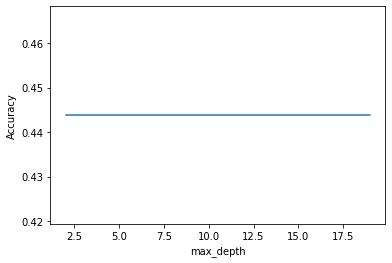

In [72]:
plt.plot(n_estimators_range, accuracy)
plt.xlabel('max_depth')
plt.ylabel('Accuracy');

### RF Classifier

In [67]:
# Instance of the Model Random Forest Classifier
rf = RandomForestClassifier(random_state = 42, max_depth=9)

rf_pipe = make_pipeline(column_transformer, rf)

rf_pipe.fit(X_train, y_train)

rf_preds = rf_pipe.predict(X_test)

In [49]:
print('Training accuracy:', rf_pipe.score(X_train, y_train))
print('Testing accuracy:', rf_pipe.score(X_test, y_test))

Training accuracy: 0.9574764726385501
Testing accuracy: 0.4438055410350235


In [50]:
#Classification report
print('Dec tree classification report:\n,', classification_report(y_test, rf_preds))

Dec tree classification report:
,               precision    recall  f1-score   support

           A       0.40      0.43      0.41       484
           B       0.31      0.29      0.30       458
           C       0.45      0.41      0.43       466
           D       0.57      0.63      0.60       505

    accuracy                           0.44      1913
   macro avg       0.44      0.44      0.44      1913
weighted avg       0.44      0.44      0.44      1913



#### RF params tuning

In [73]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [75]:
n_estimators_range = list(range(2, 20))

best_n = []
for est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators = est, 
                             random_state = 42)
    rf_pipe.fit(X_train, y_train)
    score = rf_pipe.score(X_test, y_test)
    best_n.append(score)

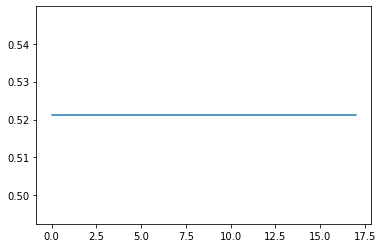

In [79]:
plt.plot(best_n)

In [76]:
max_depth_range = list(range(2, 200))

best_md = []
for depth in max_depth_range:
    rf = RandomForestClassifier(max_depth = depth, 
                             random_state = 42)
    rf_pipe.fit(X_train, y_train)
    score = rf_pipe.score(X_test, y_test)
    best_md.append(score)

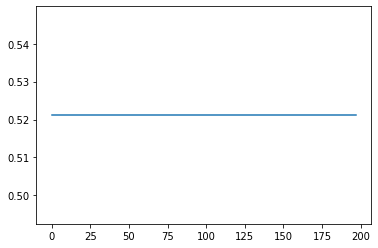

In [78]:
plt.plot(best_md)

### eXtreme Gradient Boosting

In [51]:
# Instantiate and fit XGboost
xgb = XGBClassifier()

xgb_pipe = make_pipeline(column_transformer, xgb)

xgb_pipe.fit(X_train, y_train)

xgb_preds = xgb_pipe.predict(X_test)

In [52]:
print('Training accuracy:', xgb_pipe.score(X_train, y_train))
print('Testing accuracy:', xgb_pipe.score(X_test, y_test))

Training accuracy: 0.5554200069710701
Testing accuracy: 0.5211709357030841


In [53]:
#Classification report
print('Dec tree classification report:\n,', classification_report(y_test, xgb_preds))

Dec tree classification report:
,               precision    recall  f1-score   support

           A       0.47      0.47      0.47       484
           B       0.40      0.37      0.38       458
           C       0.57      0.52      0.54       466
           D       0.61      0.71      0.66       505

    accuracy                           0.52      1913
   macro avg       0.51      0.52      0.51      1913
weighted avg       0.52      0.52      0.52      1913



### Light GBM

In [54]:
# Instantiate and fit lightGBM
lgbm = LGBMClassifier()

lgbm_pipe = make_pipeline(column_transformer, xgb)

lgbm_pipe.fit(X_train, y_train)

lgbm_preds = lgbm_pipe.predict(X_test)

In [55]:
print('Training accuracy:', lgbm_pipe.score(X_train, y_train))
print('Testing accuracy:', lgbm_pipe.score(X_test, y_test))

Training accuracy: 0.5554200069710701
Testing accuracy: 0.5211709357030841


In [56]:
#Classification report
print('Dec tree classification report:\n,', classification_report(y_test, lgbm_preds))

Dec tree classification report:
,               precision    recall  f1-score   support

           A       0.47      0.47      0.47       484
           B       0.40      0.37      0.38       458
           C       0.57      0.52      0.54       466
           D       0.61      0.71      0.66       505

    accuracy                           0.52      1913
   macro avg       0.51      0.52      0.51      1913
weighted avg       0.52      0.52      0.52      1913



### Gradient boosting classifier

In [57]:
# Instantiate and fit gradient boosting classifier
gbc = GradientBoostingClassifier()

gbc_pipe = make_pipeline(column_transformer, gbc)

gbc_pipe.fit(X_train, y_train)

gbc_preds = gbc_pipe.predict(X_test)

In [58]:
print('Training accuracy:', gbc_pipe.score(X_train, y_train))
print('Testing accuracy:', gbc_pipe.score(X_test, y_test))

Training accuracy: 0.5744161728825374
Testing accuracy: 0.5185572399372713


In [59]:
#Classification report
print('Dec tree classification report:\n,', classification_report(y_test, gbc_preds))

Dec tree classification report:
,               precision    recall  f1-score   support

           A       0.47      0.49      0.48       484
           B       0.40      0.34      0.37       458
           C       0.56      0.51      0.54       466
           D       0.61      0.71      0.66       505

    accuracy                           0.52      1913
   macro avg       0.51      0.51      0.51      1913
weighted avg       0.51      0.52      0.51      1913



Looks like our three models give us best training score, but our boosting models give us higher accuracy. Further tuning is in progress.